In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 51.8 MB/s eta 0:00:00


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt
from transformers import TFSegformerForSemanticSegmentation
from IPython.display import clear_output

In [4]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteHXVKMK/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteHXVKMK/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
IMAGE_SIZE = 512
MEAN = tf.constant([0.485, 0.456, 0.406])
STD = tf.constant([0.229, 0.224, 0.225])
AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 4

In [6]:
def normalize(img, mask):
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = (img - MEAN) / tf.maximum(STD, backend.epsilon())
  mask -= 1
  return img, mask

In [7]:
def load_image(datapoint):
  img = tf.image.resize(datapoint["image"], (IMAGE_SIZE, IMAGE_SIZE))
  mask = tf.image.resize(
      datapoint["segmentation_mask"],
      (IMAGE_SIZE, IMAGE_SIZE),
      method="bilinear"
  )
  img, mask = normalize(img, mask)
  img = tf.transpose(img, (2, 0, 1))
  return {
      "pixel_values": img,
      "labels": tf.squeeze(mask)
  }

In [9]:
train_ds = (
    dataset["train"]
    .cache()
    .shuffle(BATCH_SIZE * 10)
    .map(load_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    dataset["test"]
    .map(load_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [18]:
print(train_ds.element_spec)

{'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None), 'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.float32, name=None)}


In [14]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = [
      "Input Image",
      "True Mask",
      "Predicted Mask"
  ]
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i + 1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

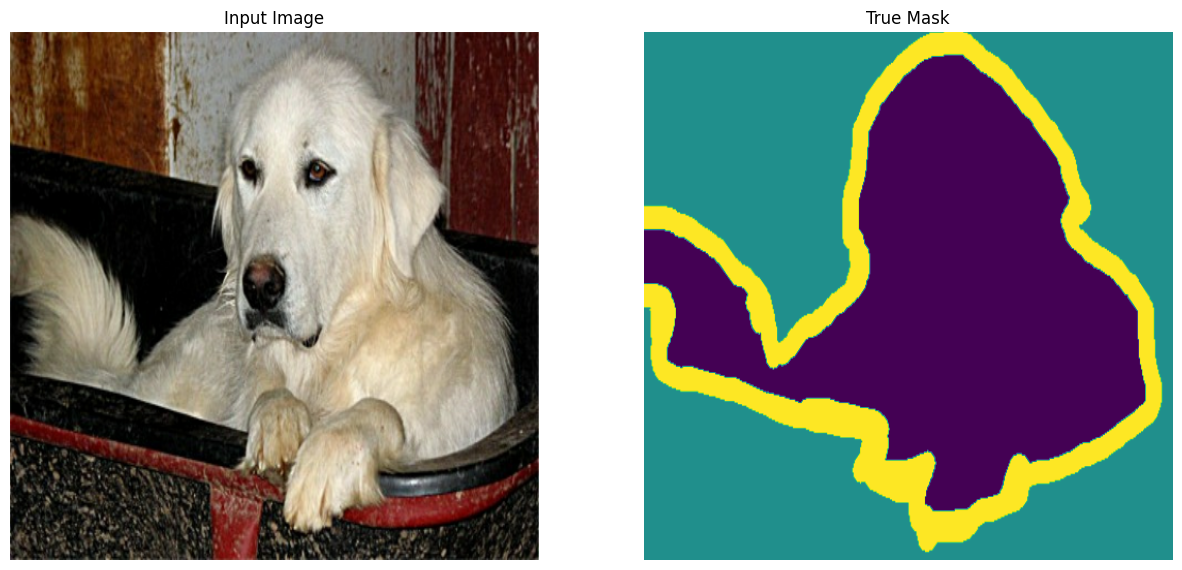

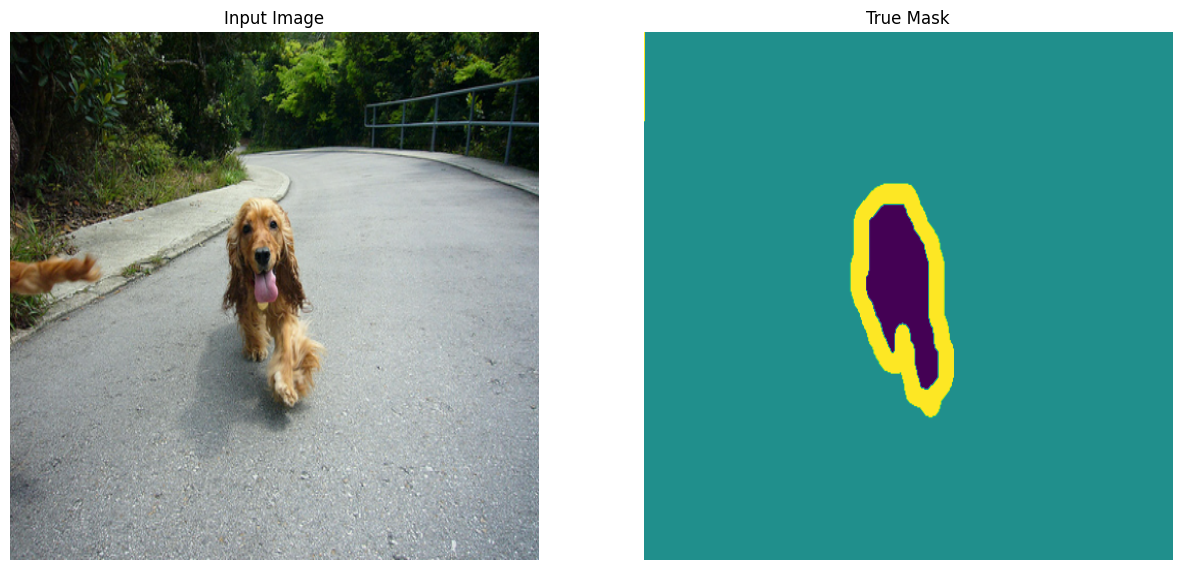

In [15]:
for samples in train_ds.take(2):
  sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
  sample_image = tf.transpose(sample_image, (1, 2, 0))
  sample_mask = tf.expand_dims(sample_mask, -1)
  display([sample_image, sample_mask])

In [16]:
model_checkpoint = "nvidia/mit-b0"
id2label = {0: "outer", 1: "inner", 2:"border"}
label2id = {label:id for id, label in id2label.items()}
num_labels = len(id2label)

In [19]:
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some layers from the model checkpoint at nvidia/mit-b0 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
lr = 0.00006
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [21]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=1)
  pred_mask = tf.expand_dims(pred_mask, -1)
  return pred_mask[0]

In [22]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for sample in dataset.take(num):
      images, masks = sample["pixel_values"], sample["labels"]
      masks = tf.expand_dims(masks, -1)
      pred_masks = model.predict(images).logits
      images = tf.transpose(images, (0, 2, 3, 1))
      display([images[0], masks[0], create_mask(pred_masks)])
  else:
    display([
        sample_image, 
        sample_mask, 
        create_mask(
            model.predict(tf.expand_dims(sample_image, 0))
        )
    ])

In [23]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def __init__(self, dataset, **kwargs):
    super().__init__(**kwargs)
    self.dataset = dataset

  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions(self.dataset)
    print("\nSample Prediction after epoch {}\n".format(epoch + 1))

In [24]:
epochs = 5

1/1 [==============================] - 0s 100ms/step


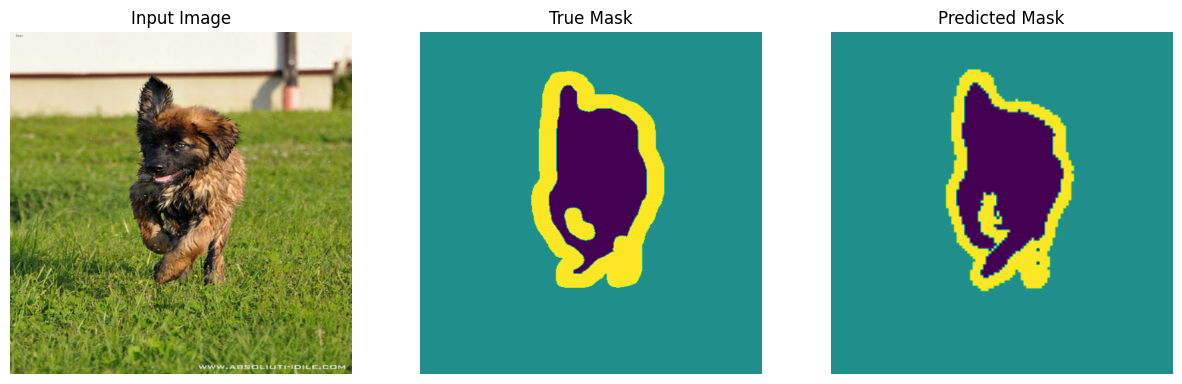


Sample Prediction after epoch 5

920/920 [==============================] - 342s 372ms/step - loss: 0.1702 - val_loss: 0.1925


In [25]:
history = model.fit(
    train_ds, 
    validation_data=test_ds,
    callbacks=[DisplayCallback(test_ds)],
    epochs=epochs
)

1/1 [==============================] - 0s 125ms/step


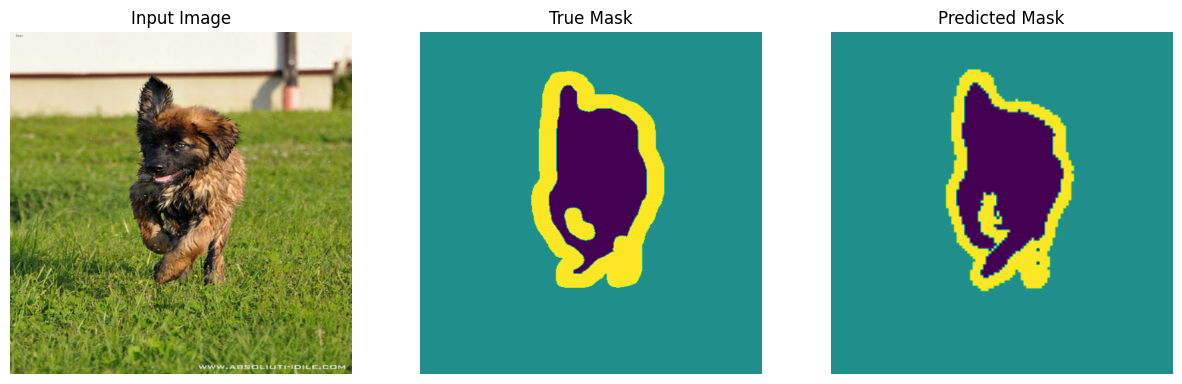

1/1 [==============================] - 0s 125ms/step


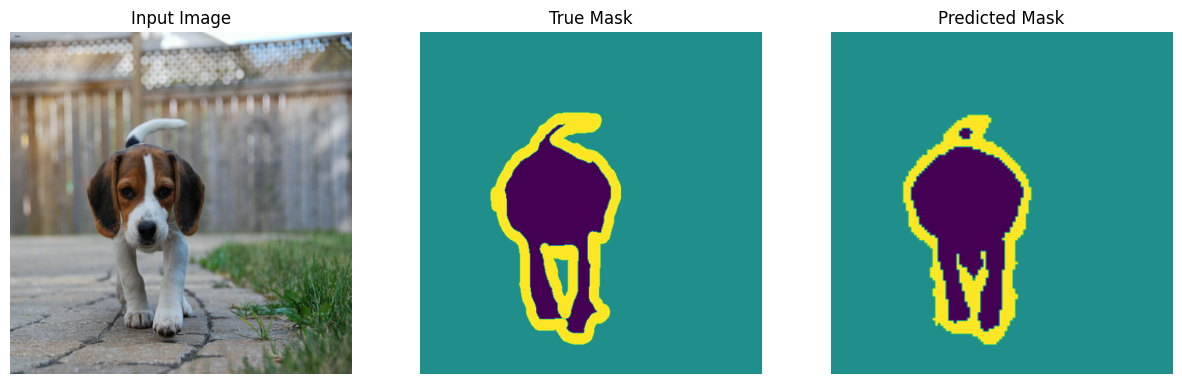

1/1 [==============================] - 0s 124ms/step


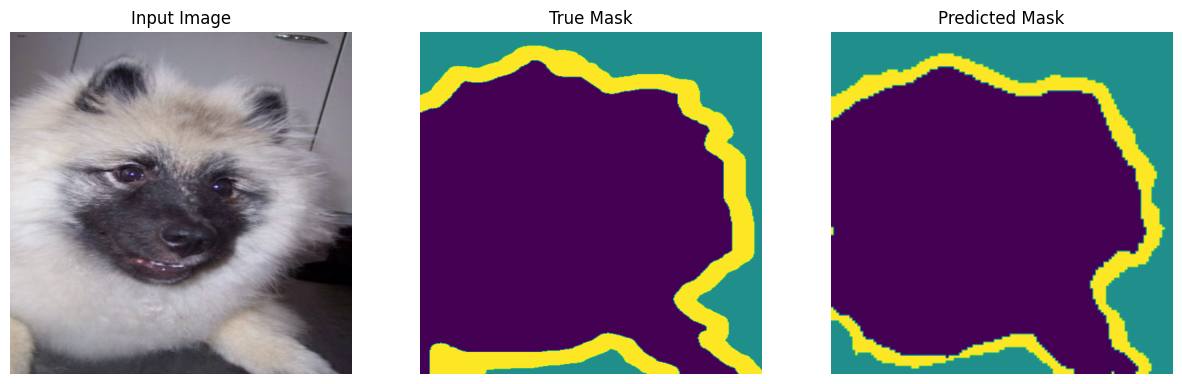

1/1 [==============================] - 0s 122ms/step


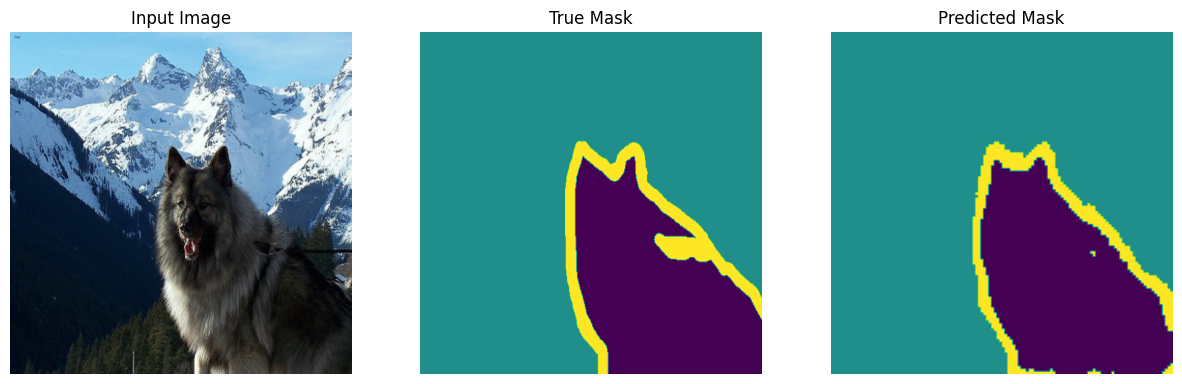

1/1 [==============================] - 0s 119ms/step


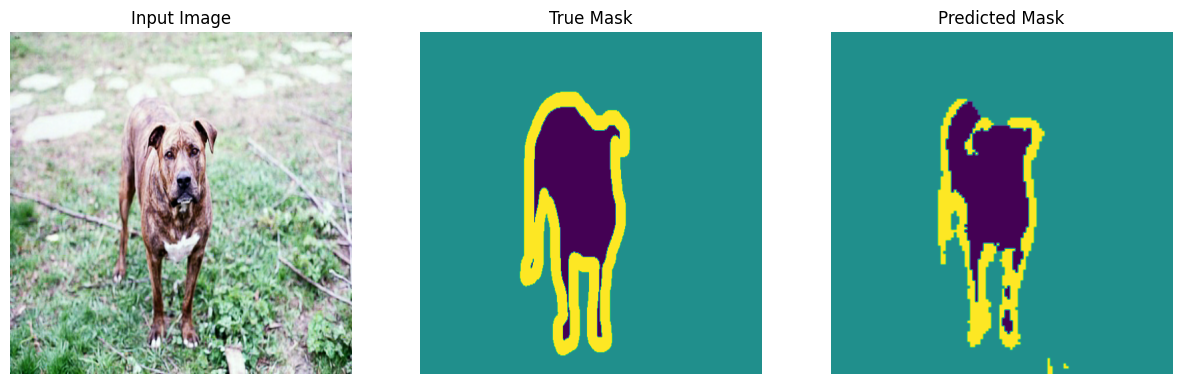

In [26]:
show_predictions(test_ds, 5)